In [1]:
import os
import torch
import random
import sys

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

from matplotlib import cm
from torch.amp import autocast, GradScaler
from scipy.linalg import expm
from qutip import Bloch, Qobj

In [2]:
# Hyperparameters
LEARNING_RATE = 1e-4
GAMMA = 0.9
BATCH_SIZE = 512
MAX_STEPS = 10
EPISODES = 200000
PATIENCE = EPISODES / 2
FIDELITY_THRESHOLD = 1e-5

# Define Pauli matrices
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
# Define Hamiltonian parameters
omega = 1.0
J = 0.1

# Define Gates
HADAMARD = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
T_GATE = np.array([[1, 0], [0, np.exp(1j * np.pi / 4)]], dtype=np.complex128)
CNOT = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])

GPU Management

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
!set 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:2'
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [5]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.cuda.empty_cache()

In [6]:
print("__Python VERSION:", sys.version)
print("__pyTorch VERSION:", torch.__version__)

__Python VERSION: 3.12.3 (main, Sep  4 2024, 12:08:24) [GCC 13.2.0]
__pyTorch VERSION: 2.4.1+cu124


In [7]:
print("__CUDA VERSION")
!nvidia-smi

__CUDA VERSION
Sun Sep  8 07:15:45 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti     Off |   00000000:01:00.0  On |                  N/A |
| N/A   51C    P5              8W /   50W |      96MiB /   4096MiB |     37%      Default |
|                                         |                        |                  N/A |
+--------------------------------

In [8]:
print("__CUDNN VERSION:", torch.backends.cudnn.version())
!nvcc --version

__CUDNN VERSION: 90100
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Wed_Aug_14_10:10:22_PDT_2024
Cuda compilation tools, release 12.6, V12.6.68
Build cuda_12.6.r12.6/compiler.34714021_0


In [9]:
print("__Number CUDA Devices:", torch.cuda.device_count())
print("__Devices")
print("Available devices ", torch.cuda.device_count())
print("Active CUDA Device: GPU", torch.cuda.current_device())

__Number CUDA Devices: 1
__Devices
Available devices  1
Active CUDA Device: GPU 0


In [10]:
class QuantumGateEnv:
    """
    A class to represent the environment for quantum gate control using reinforcement learning.
    
    Attributes:
    ----------
    gate : str
        The type of quantum gate (e.g., 'H', 'T', 'CNOT').
    control_pulse_params : dict
        Dictionary containing amplitude, phase, and duration parameters for control pulses.
    initial_state : np.ndarray
        The initial quantum state of the system.
    state : np.ndarray
        The current quantum state of the system.
    target : np.ndarray
        The target quantum gate matrix.
    theoretical_state : np.ndarray
        The expected quantum state after applying the target gate.
    time_step : int
        The current time step in the episode.
    max_steps : int
        The maximum number of steps in an episode.
    state_history : list
        A history of quantum states during an episode.
    """
    def __init__(self, gate):
        """
        Initializes the QuantumGateEnv with the specified gate type.

        Parameters:
        ----------
        gate : str
            The type of quantum gate (e.g., 'H', 'T', 'CNOT').
        """
        self.control_pulse_params = {
            'amplitude': np.linspace(0, 1, 12),  # Example amplitudes
            'phase': np.linspace(-np.pi, np.pi, 12),  # Example phases
            'duration': np.linspace(0.1, 1.0, 120)  # Example durations
        }
        self.gate = gate
        (
            self.initial_state,
            self.target_state,
            self.state_size,
            self.action_size,
            self.input_features,
            self.hidden_features
        ) = self.set_quantum_info()
        self.reset()

    def set_quantum_info(self):
        """
        Sets the quantum information for the environment based on the gate type.

        Returns:
        -------
        tuple
            A tuple containing the initial state, target_state, state size, action size, and input features.
        """
        action_size = len(self.control_pulse_params['amplitude']) * len(self.control_pulse_params['phase']) * len(self.control_pulse_params['duration'])

        if self.gate in ["H", "T"]:
            num_qubits = 1
            state_size = 2**num_qubits
            initial_states = [np.array([1, 0], dtype=np.complex128), np.array([0, 1], dtype=np.complex128)]
            initial_state = random.choice(initial_states)
            input_features = 2 ** (
                num_qubits + 1
            )  # Number of states in the input space
            hidden_features = 512
            unitary = HADAMARD if self.gate == "H" else T_GATE
            target_state = np.dot(initial_state, unitary)

        elif self.gate == 'CNOT':
            num_qubits = 2
            state_size = 2**num_qubits
            initial_states = [
            np.array([1, 0, 0, 0], dtype=np.complex128),
            np.array([0, 1, 0, 0], dtype=np.complex128),
            np.array([0, 0, 1, 0], dtype=np.complex128),
            np.array([0, 0, 0, 1], dtype=np.complex128),
            ]
            initial_state = random.choice(initial_states)
            input_features = 2 ** (
                num_qubits + 1
            )  # Number of states in the input space
            hidden_features = 512
            unitary = CNOT
            target_state = np.dot(initial_state, unitary)

        return (
            initial_state,
            target_state,
            state_size,
            action_size,
            input_features,
            hidden_features,
        )

    def reset(self):
        """
        Resets the environment to the initial state.

        Returns:
        -------
        np.ndarray
            The initial quantum state.
        """
        self.state = self.initial_state.copy()
        self.time_step = 0
        self.max_steps = MAX_STEPS
        self.reward_episode = [-1]
        self.fidelity_episode = [0]
        self.state_episode = [self.state]
        self.amplitude_episode = [0]
        self.phase_episode = [0]
        self.duration_episode = [0]
        return self.state

    def _time_evolution_operator(self, H, t):
        """
        Compute the time evolution operator U(t) = exp(-i * H * t).

        Parameters:
        H (ndarray): The Hamiltonian matrix.
        t (float): The time over which to evolve the system.

        Returns:
        ndarray: The time evolution operator U(t).
        """
        return expm(-1j * H * t)

    def _construct_hamiltonian(self, amplitude, phase):
        """
        Constructs the Hamiltonian for the quantum gate operation based on the gate type.

        Parameters:
        ----------
        amplitude : float
            The amplitude of the control Hamiltonian, which modulates the strength of the control fields.
        phase : float
            The phase of the control Hamiltonian, which determines the direction of the control field in the XY-plane.

        Returns:
        -------
        H_total : ndarray
            The total Hamiltonian (system + control) for the specified gate operation.
            If the gate is "H" or "T", returns a 2x2 matrix.
            If the gate is "CNOT", returns a 4x4 matrix.
        """
        if self.gate in ["H", "T"]:
            H_sys = (omega / 2) * Z  # System Hamiltonian (static)
            H_control = amplitude * (
                np.cos(phase) * X + np.sin(phase) * Y
            )  # Control Hamiltonian (depends on amplitude and phase)
            return H_sys + H_control  # Total Hamiltonian
        elif self.gate == "CNOT":
            H_system = (
                (omega / 2) * np.kron(Z, I)
                + (omega / 2) * np.kron(I, Z)
                + J * (np.kron(X, X) + np.kron(Y, Y))
            )  # System Hamiltonian (static)
            H_control = amplitude * (
                np.kron(X, I) * np.cos(phase) + np.kron(Y, I) * np.sin(phase)
            )  # Control Hamiltonian (depends on amplitude and phase)
            return H_system + H_control  # Total Hamiltonian
        
    def infidelity(self, final_state):
        """
        Calculates the infidelity between the final state and the theoretical state.

        Parameters:
        ----------
        final_state (np.ndarray): The final quantum state after applying the control pulse.

        Returns:
        -------
        float
            The infidelity between the final state and the theoretical state.
        """
        fidelity = np.abs(np.dot(np.conjugate(self.target_state), final_state)) ** 2
        return 1 - fidelity

    def step(self, action):
        """
        Takes a step in the environment using the given action.

        Parameters:
        ----------
        action : int
            The action to be taken by the agent.

        Returns:
        -------
        tuple
            A tuple containing the next state, reward, and done flag.
        """
        self.time_step += 1

        num_phases = len(self.control_pulse_params["phase"])
        num_durations = len(self.control_pulse_params["duration"])

        amplitude_index = action // (num_phases * num_durations)
        phase_index = (action // num_durations) % num_phases
        duration_index = action % num_durations

        amplitude = self.control_pulse_params["amplitude"][amplitude_index]
        phase = self.control_pulse_params["phase"][phase_index]
        duration = self.control_pulse_params["duration"][duration_index]

        # Apply control pulse
        control_hamiltonian = self._construct_hamiltonian(amplitude, phase)
        control_matrix = self._time_evolution_operator(control_hamiltonian, duration)

        next_state = np.dot(control_matrix, self.state)
        self.state = next_state

        # Store episode
        self.state_episode.append(self.state)
        self.amplitude_episode.append(amplitude)
        self.phase_episode.append(phase)
        self.duration_episode.append(duration)

        # Calculate reward
        reward = -self.infidelity(next_state) if self.time_step == self.max_steps else 0
        fidelity = 1 + reward
        self.reward_episode.append(reward)
        self.fidelity_episode.append(fidelity)
        done = self.time_step == self.max_steps

        return (
            done,
            next_state,
            amplitude,
            phase,
            duration,
            reward,
            fidelity,
        )

In [11]:
# Actor-Critic Network
class ActorCriticNetwork(nn.Module):
    def __init__(self, state_size, action_size, dropout=0.1):
        super(ActorCriticNetwork, self).__init__()
        self.fc1 = nn.Linear(env.input_features, env.hidden_features)
        # Actor
        self.actor = nn.Linear(env.hidden_features, env.action_size)
        # Critic
        self.critic = nn.Linear(env.hidden_features, 1)
        self.dropout = nn.Dropout(dropout)
        self._initialize_weights()

    def forward(self, state):
        x = self.dropout(torch.relu(self.fc1(state)))
        action_probs = torch.softmax(self.actor(x), dim=-1)
        state_value = self.critic(x)
        return action_probs, state_value
    
    def _initialize_weights(self):
        def init_weights(layer):
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity="relu")
                nn.init.zeros_(layer.bias)
        self.apply(init_weights)

In [12]:
# Actor-Critic Agent
class ActorCriticAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.network = ActorCriticNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(
        self.network.parameters(),
            lr=LEARNING_RATE,
            amsgrad=True,
            weight_decay=LEARNING_RATE * 0.1,
        )
        self.scaler = GradScaler(device=device.type)

    def select_action(self, state):
        state = torch.FloatTensor(np.array(np.concatenate([state.real, state.imag]))).to(device)
        with autocast(device_type=device.type):
            action_probs, _ = self.network(state)
            dist = torch.distributions.Categorical(action_probs)
            action = dist.sample()
        return action.item(), dist.log_prob(action)

    def update(self, trajectory):
        states, actions, rewards, log_probs, values = zip(*trajectory)
        states = torch.FloatTensor(
            np.array([np.concatenate([s.real, s.imag]) for s in states])
        ).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        log_probs = torch.stack(log_probs)
        values = torch.stack(values)

        # Calculate discounted rewards
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + GAMMA * R
            returns.insert(0, R)
        returns = torch.FloatTensor(returns).to(device)

        # Normalize returns
        returns = (returns - returns.mean()) / (returns.std() + 1e-10)

        # Calculate advantages
        advantages = returns - values

        # Calculate loss
        actor_loss = -log_probs * advantages.detach()
        critic_loss = advantages.pow(2)
        loss = actor_loss.sum() + critic_loss.sum()

        self.optimizer.zero_grad(set_to_none=True)
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()

In [13]:
# Training the agent
def train_agent(agent, env, episodes, fidelity_threshold, patience):

    reward_history = []
    fidelity_history = []
    state_history = []
    amplitude_history = []
    phase_history = []
    duration_history = []
    best_fidelity = 0
    patience_counter = 0

    for e in range(episodes):
        state = env.reset()
        trajectory = []
        total_reward = 0

        for _ in range(env.max_steps):
            action, log_prob = agent.select_action(state)
            (done, next_state, amplitude, phase, duration, reward, fidelity) = env.step(
                action
            )
            _, value = agent.network(
                torch.FloatTensor(
                    np.array(np.concatenate([state.real, state.imag]))
                ).to(device)
            )
            trajectory.append((state, action, reward, log_prob, value))
            state = next_state
            total_reward += reward

            if done:
                break

        agent.update(trajectory)

        state_history.append(state)
        amplitude_history.append(amplitude)
        phase_history.append(phase)
        duration_history.append(duration)
        reward_history.append(total_reward)
        fidelity_history.append(fidelity)

        if e % (EPISODES / 100) == 0:
            print(
                f"Episode: {e}/{episodes},  Reward: {total_reward:.5f}, "
                f"Fidelity: {fidelity_history[-1]:.5f}"
            )

        current_fidelity = 1 - env.infidelity(state)
        # Early stopping check
        if current_fidelity >= best_fidelity:
            best_fidelity = current_fidelity
            patience_counter = 0  # Reset patience counter if fidelity improves
        else:
            patience_counter += 1

        if best_fidelity >= (1 - fidelity_threshold) or patience_counter >= patience:
            print(
                f"Early stopping triggered. Achieved fidelity: {best_fidelity:.5f}, "
                f"Episode: {e}, Patience: {patience_counter}, Reward: {total_reward:.5f}"
            )
            break

    print("Training finished.")
    return (
        reward_history,
        fidelity_history,
        state_history,
        amplitude_history,
        phase_history,
        duration_history,
    )

In [14]:
def plot_results(
    rewards, fidelities, amplitudes, phases, durations, last_episode=False
):
    """
    Plots the results of the training process, including rewards,
    fidelities, and control pulse parameters.

    Parameters:
    ----------
    rewards : list
        A list of rewards per episode.
    fidelities : list
        A list of fidelities per episode.
    amplitudes : list
        A list of amplitudes of control pulses per episode.
    phases : list
        A list of phases of control pulses per episode.
    durations : list
        A list of durations of control pulses per episode.
    last_episode : bool, optional
        If True, indicates that the data is from the last episode only.
        In this case, the x-axis will not be logarithmic.
    """
    data = [
        (rewards, "Reward per Episode", "Reward"),
        (fidelities, "Fidelity per Episode", "Fidelity"),
        (amplitudes, "Amplitude per Episode", "Amplitude", "r"),
        (phases, "Phase per Episode", "Phase", "g"),
        (durations, "Duration per Episode", "Duration", "b"),
    ]

    plt.figure(figsize=(15, 20))

    for i, (data_series, label, ylabel, *color) in enumerate(data):
        plt.subplot(5, 1, i + 1)
        plt.plot(data_series, label=label, color=color[0] if color else None)

        # Apply log scale if not last episode and data is long enough
        if not last_episode:
            plt.xscale("log")

        plt.xlabel("Episode" if not last_episode else "Step")
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid()

    plt.tight_layout()
    plt.show()

In [15]:
def plot_bloch_sphere_trajectory(states):
    bloch = Bloch()
    # Add states
    for state in states:
        bloch.add_states(Qobj(state))
    bloch.show()
    plt.show()

H-Gate

In [16]:
# Initialize environment and agent
env = QuantumGateEnv(gate='H')
agent = ActorCriticAgent(env.state_size, env.action_size)

In [17]:
# Compile the model (requires PyTorch 2.0 or later)
if torch.__version__ >= "2.0.0":
    agent.network= torch.compile(agent.network)

In [18]:
# Train the agent
(
    reward_history,
    fidelity_history,
    state_history,
    amplitude_history,
    phase_history,
    duration_history,
) = train_agent(agent, env, EPISODES, FIDELITY_THRESHOLD, PATIENCE)

Episode: 0/200000,  Reward: -0.82819, Fidelity: 0.17181
Episode: 2000/200000,  Reward: -0.42563, Fidelity: 0.57437
Episode: 4000/200000,  Reward: -0.82484, Fidelity: 0.17516
Episode: 6000/200000,  Reward: -0.64530, Fidelity: 0.35470
Episode: 8000/200000,  Reward: -0.22616, Fidelity: 0.77384
Episode: 10000/200000,  Reward: -0.93329, Fidelity: 0.06671
Episode: 12000/200000,  Reward: -0.66745, Fidelity: 0.33255
Episode: 14000/200000,  Reward: -0.99254, Fidelity: 0.00746
Episode: 16000/200000,  Reward: -0.81306, Fidelity: 0.18694
Episode: 18000/200000,  Reward: -0.65479, Fidelity: 0.34521
Episode: 20000/200000,  Reward: -0.43982, Fidelity: 0.56018
Episode: 22000/200000,  Reward: -0.66259, Fidelity: 0.33741
Episode: 24000/200000,  Reward: -0.41570, Fidelity: 0.58430
Episode: 26000/200000,  Reward: -0.28594, Fidelity: 0.71406
Episode: 28000/200000,  Reward: -0.04592, Fidelity: 0.95408
Episode: 30000/200000,  Reward: -0.12146, Fidelity: 0.87854
Episode: 32000/200000,  Reward: -0.36701, Fideli

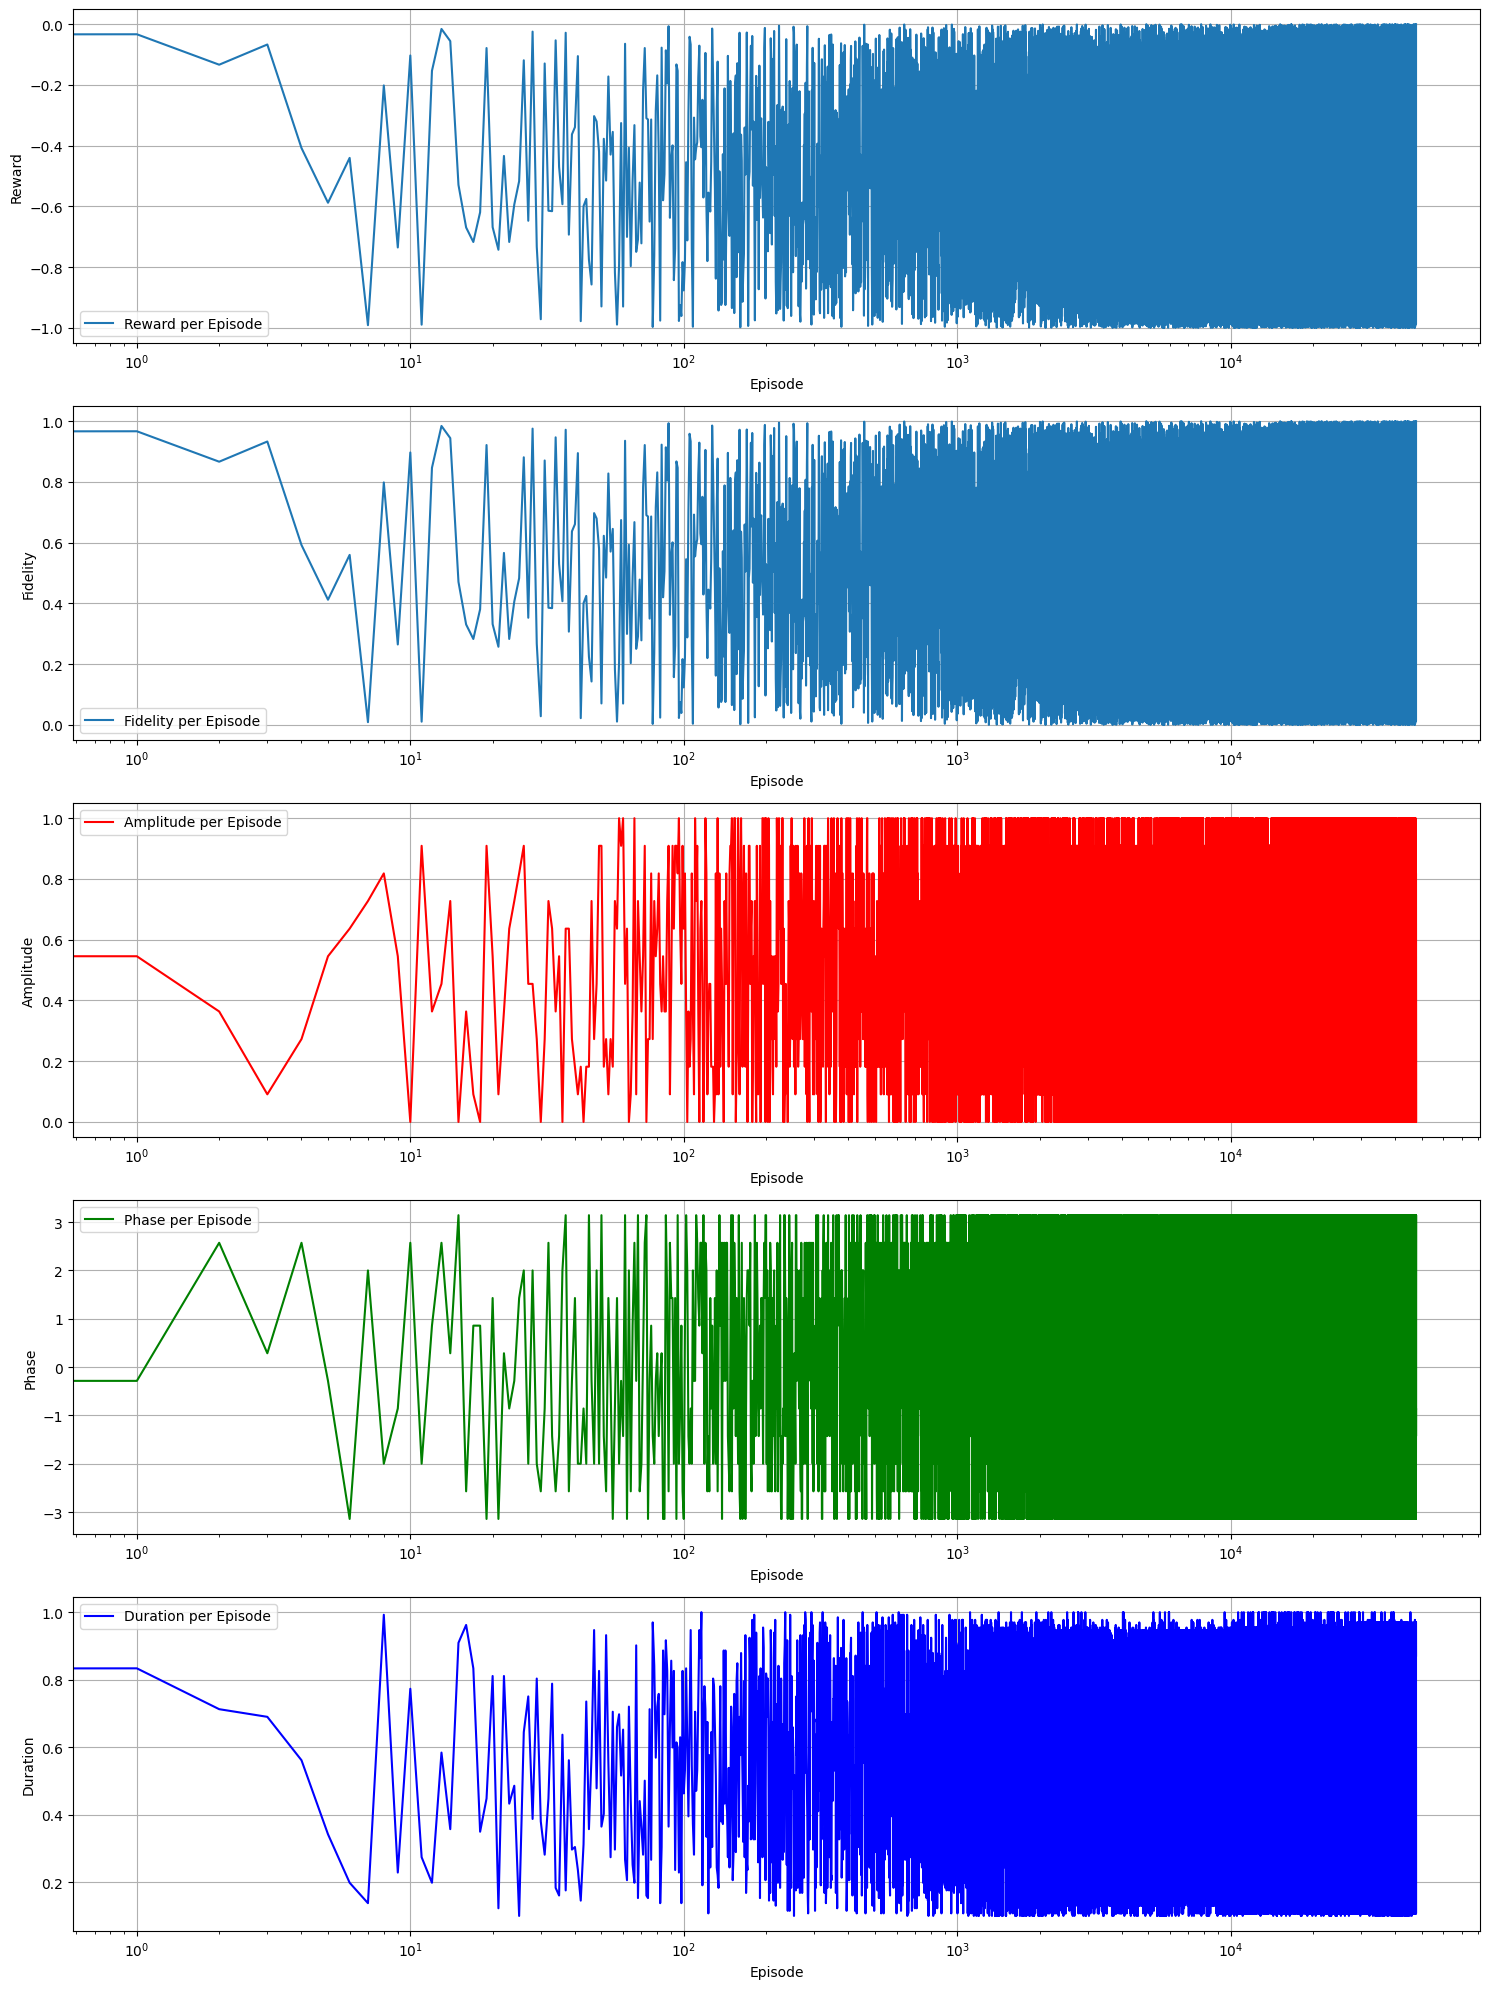

In [19]:
# Plot Results
plot_results(
    reward_history,
    fidelity_history,
    amplitude_history,
    phase_history,
    duration_history,
    False,
)

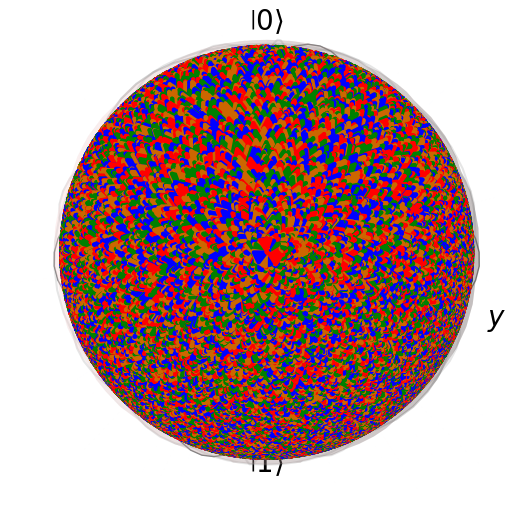

In [20]:
# Plot Bloch Sphere
plot_bloch_sphere_trajectory(state_history)

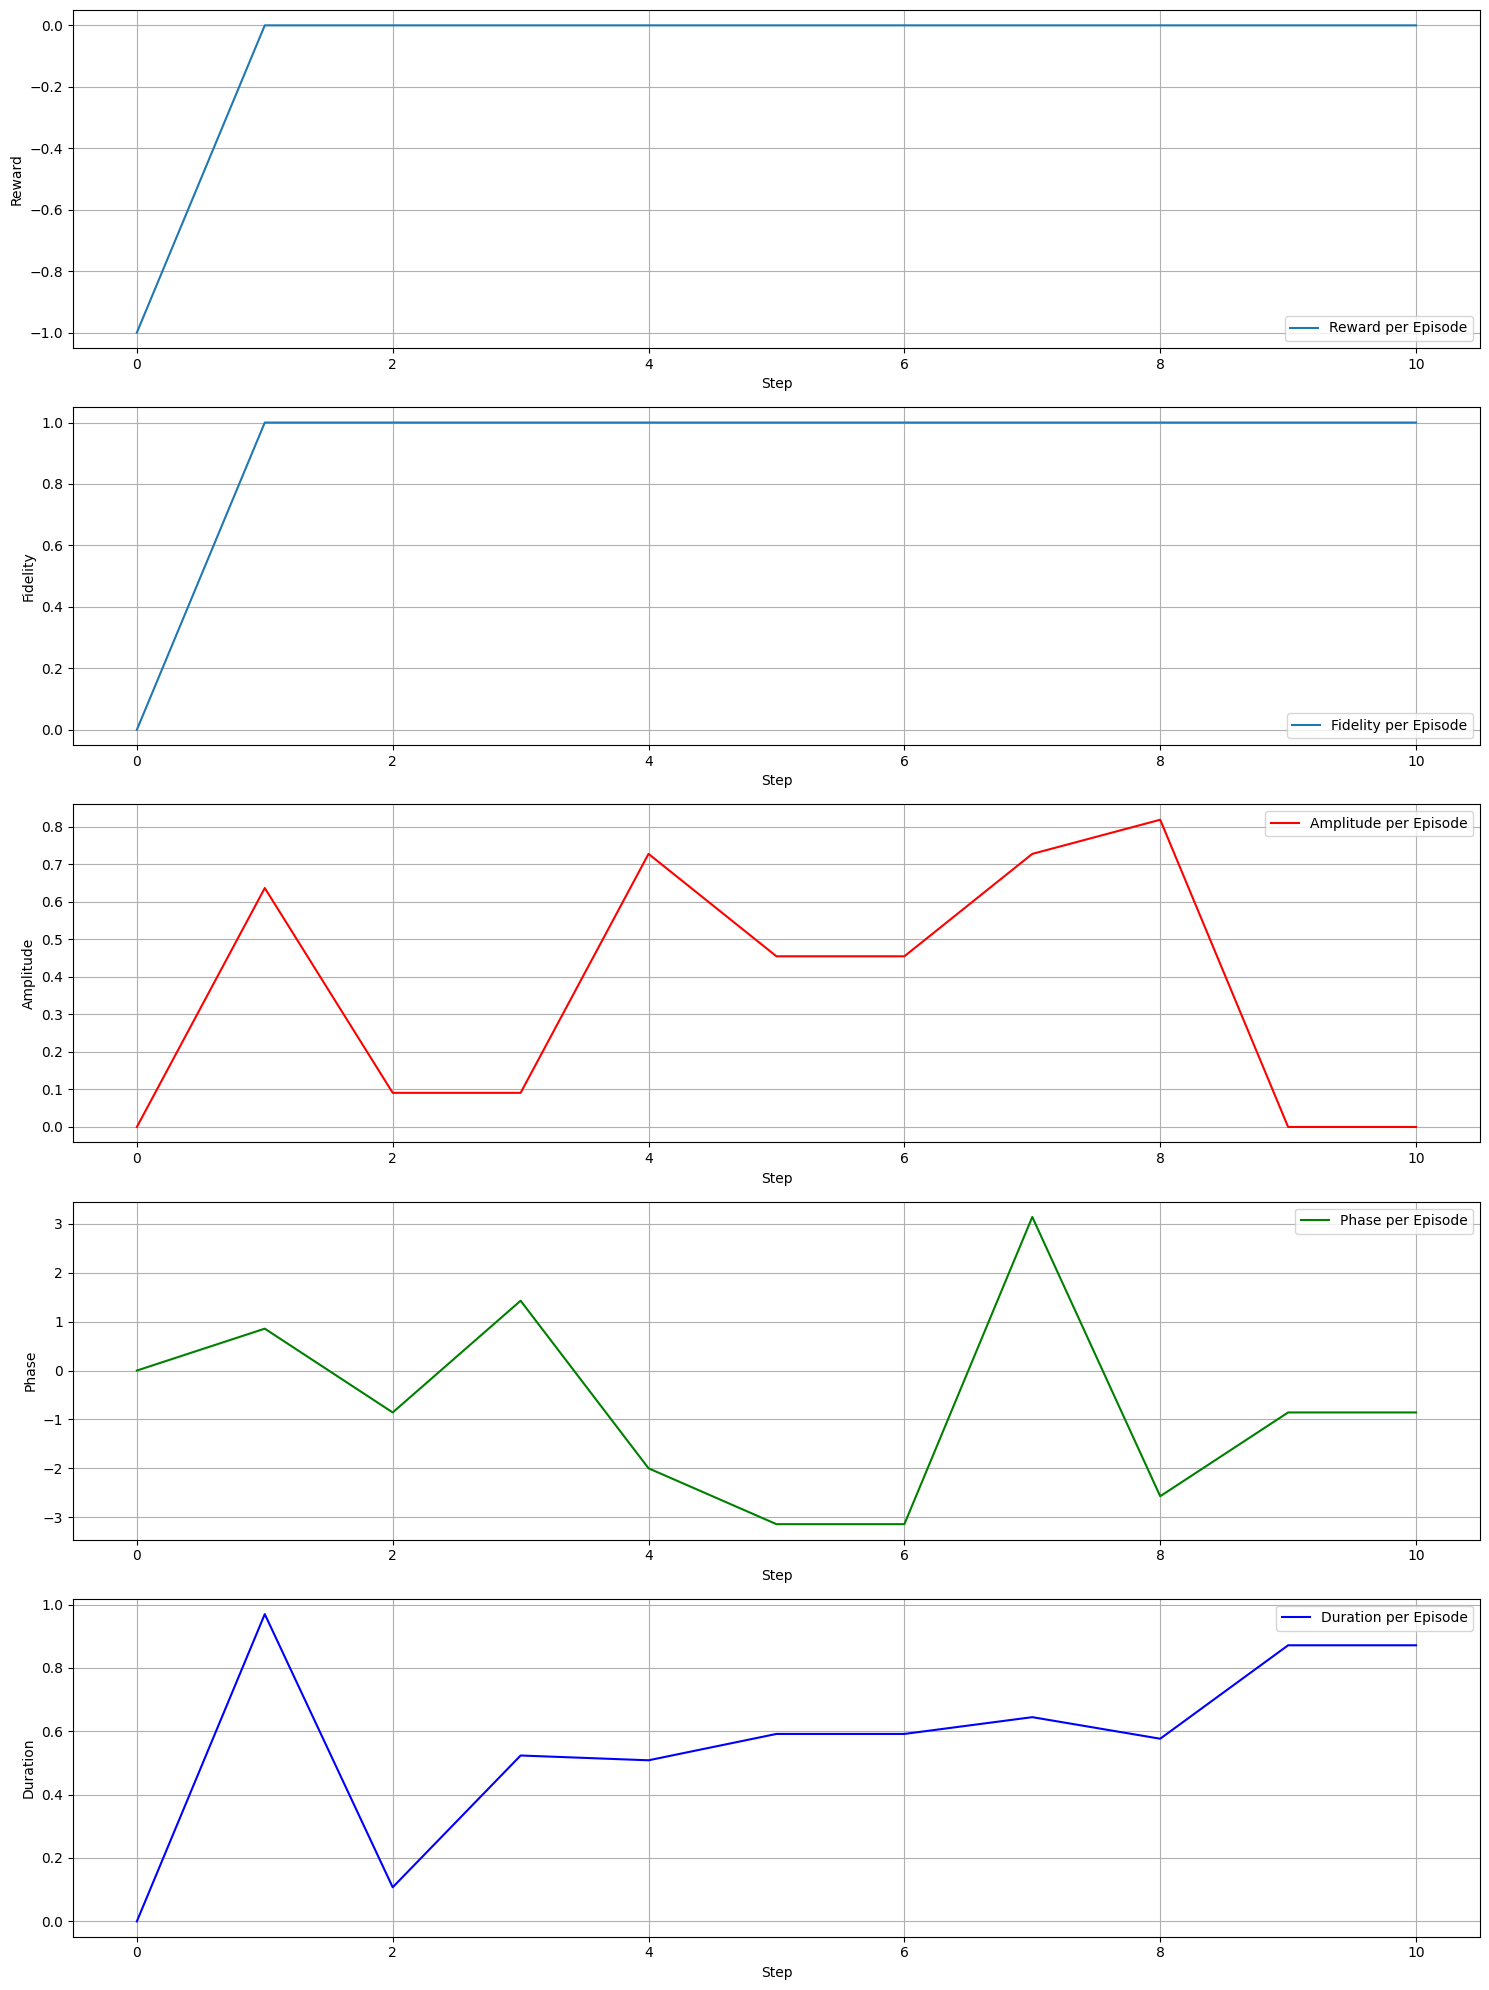

In [21]:
plot_results(
    env.reward_episode,
    env.fidelity_episode,
    env.amplitude_episode,
    env.phase_episode,
    env.duration_episode,
    True,
)

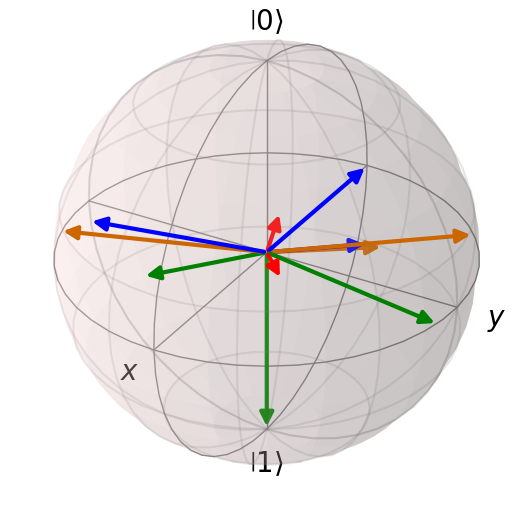

In [22]:
plot_bloch_sphere_trajectory(env.state_episode)

T-Gate

In [23]:
env = QuantumGateEnv(gate="T")
agent = ActorCriticAgent(env.state_size, env.action_size)

if torch.__version__ >= "2.0.0":
    agent.network = torch.compile(agent.network)

(
    reward_history,
    fidelity_history,
    state_history,
    amplitude_history,
    phase_history,
    duration_history,
) = train_agent(agent, env, EPISODES, FIDELITY_THRESHOLD, PATIENCE)

Episode: 0/200000,  Reward: -0.49928, Fidelity: 0.50072
Episode: 2000/200000,  Reward: -0.31131, Fidelity: 0.68869
Episode: 4000/200000,  Reward: -0.00567, Fidelity: 0.99433
Episode: 6000/200000,  Reward: -0.15924, Fidelity: 0.84076
Episode: 8000/200000,  Reward: -0.30142, Fidelity: 0.69858
Episode: 10000/200000,  Reward: -0.23428, Fidelity: 0.76572
Episode: 12000/200000,  Reward: -0.24402, Fidelity: 0.75598
Episode: 14000/200000,  Reward: -0.15276, Fidelity: 0.84724
Episode: 16000/200000,  Reward: -0.85738, Fidelity: 0.14262
Episode: 18000/200000,  Reward: -0.02308, Fidelity: 0.97692
Episode: 20000/200000,  Reward: -0.36970, Fidelity: 0.63030
Episode: 22000/200000,  Reward: -0.66275, Fidelity: 0.33725
Early stopping triggered. Achieved fidelity: 1.00000, Episode: 23109, Patience: 0, Reward: -0.00000
Training finished.


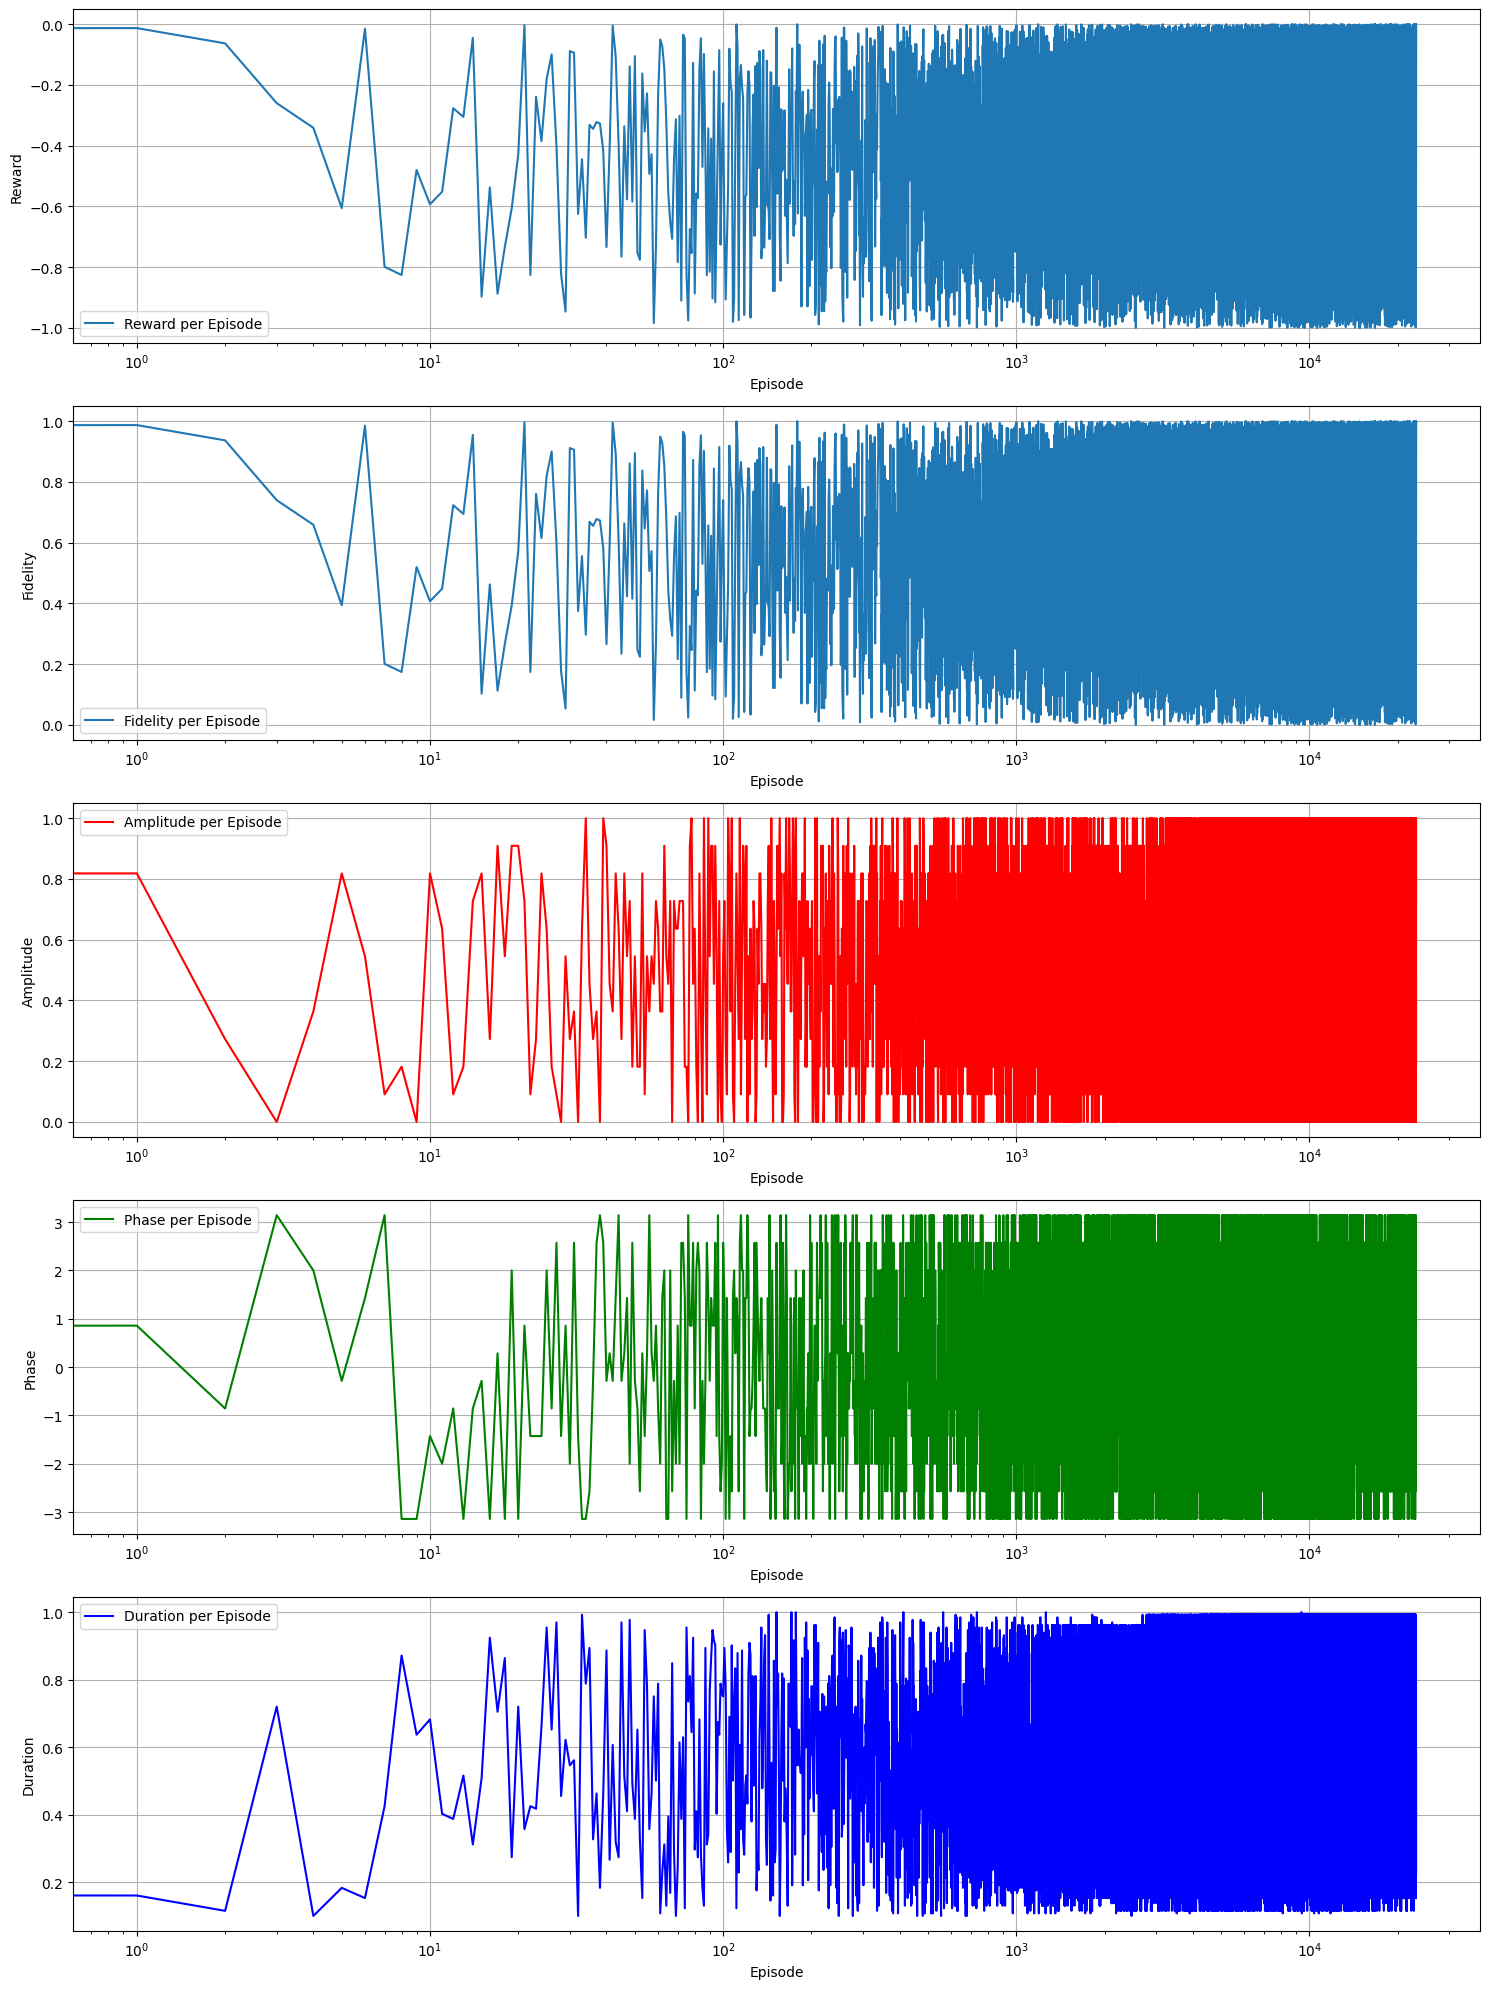

In [24]:
# Plot Results
plot_results(
    reward_history,
    fidelity_history,
    amplitude_history,
    phase_history,
    duration_history,
    False,
)

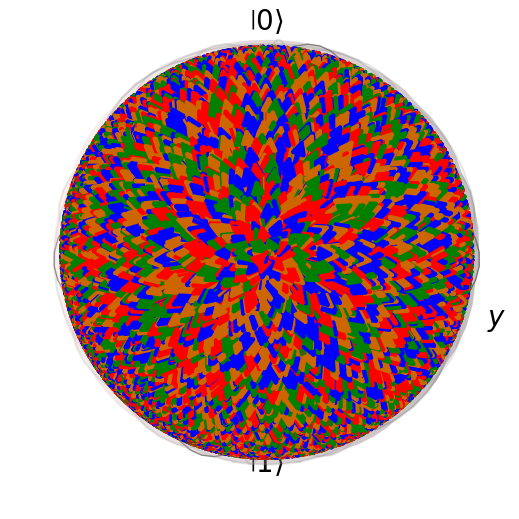

In [25]:
# Plot Bloch Sphere
plot_bloch_sphere_trajectory(state_history)

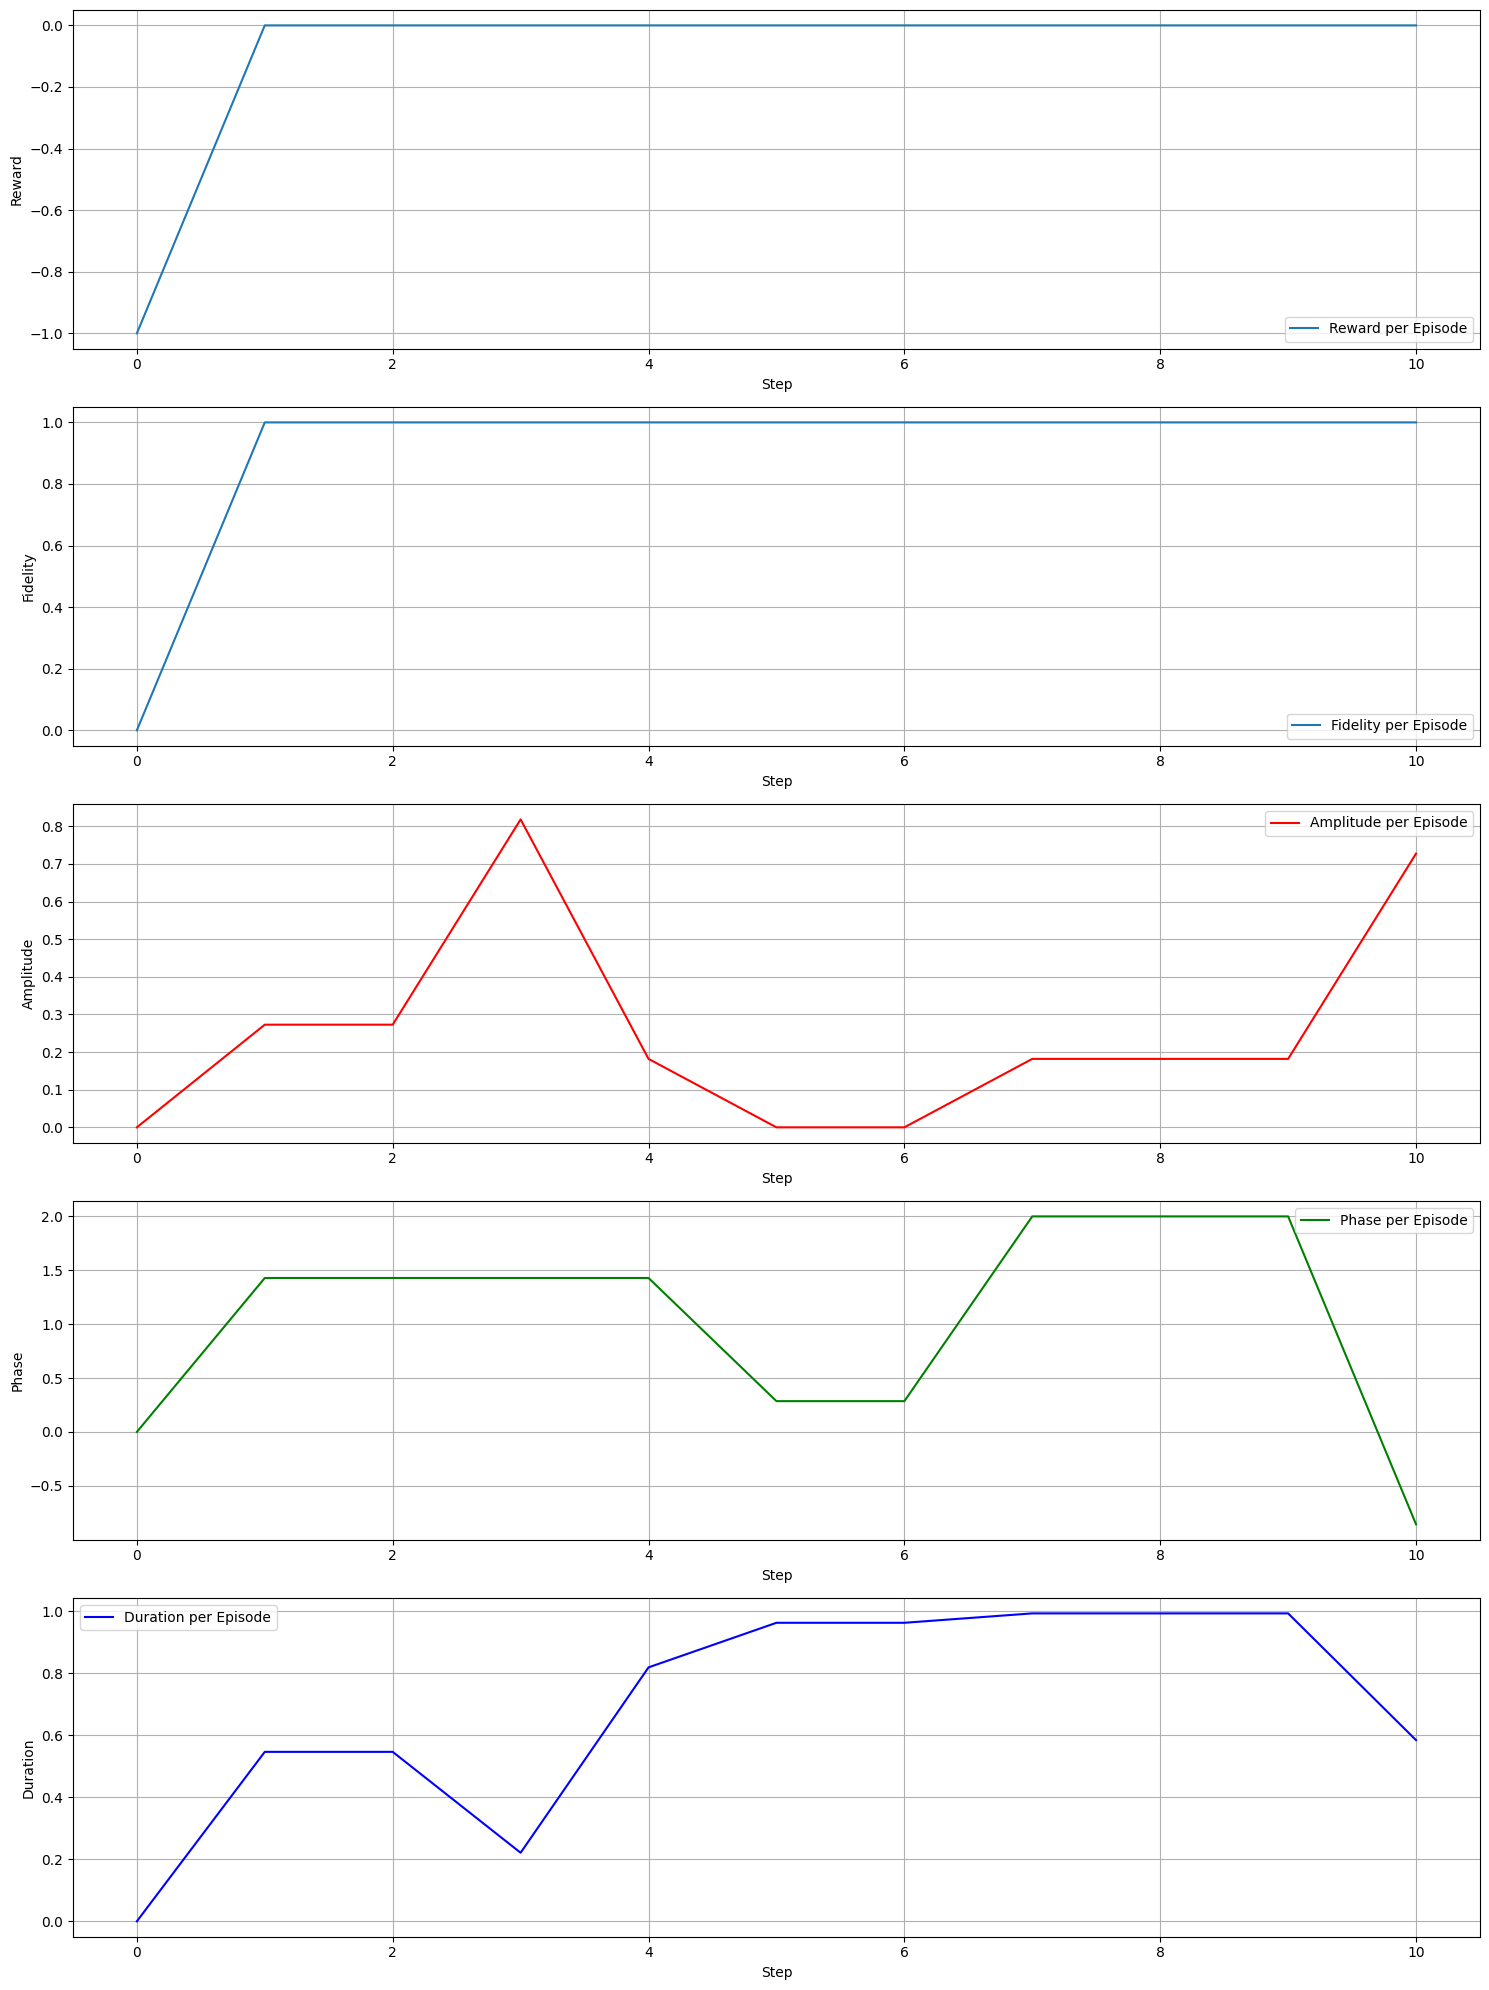

In [26]:
plot_results(
    env.reward_episode,
    env.fidelity_episode,
    env.amplitude_episode,
    env.phase_episode,
    env.duration_episode,
    True,
)

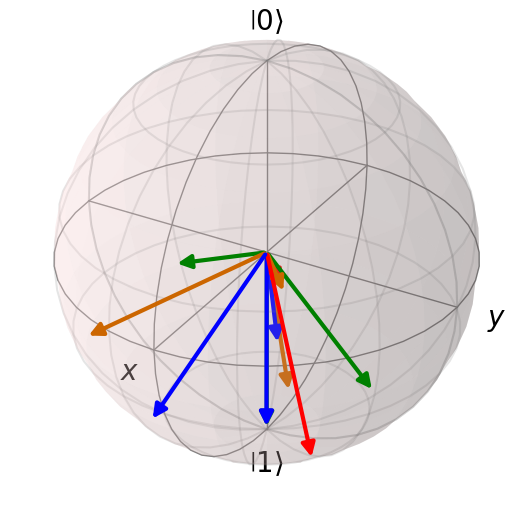

In [27]:
plot_bloch_sphere_trajectory(env.state_episode)

CNOT-Gate

In [28]:
env = QuantumGateEnv(gate="CNOT")
agent = ActorCriticAgent(env.state_size, env.action_size)

if torch.__version__ >= "2.0.0":
    agent.network = torch.compile(agent.network)

(
    reward_history,
    fidelity_history,
    state_history,
    amplitudes_history,
    phases_history,
    durations_history,
) = train_agent(agent, env, EPISODES, FIDELITY_THRESHOLD, PATIENCE)

Episode: 0/200000,  Reward: -0.89354, Fidelity: 0.10646
Episode: 2000/200000,  Reward: -0.64201, Fidelity: 0.35799
Episode: 4000/200000,  Reward: -0.96864, Fidelity: 0.03136
Episode: 6000/200000,  Reward: -0.94099, Fidelity: 0.05901
Episode: 8000/200000,  Reward: -0.94066, Fidelity: 0.05934
Episode: 10000/200000,  Reward: -0.64589, Fidelity: 0.35411
Episode: 12000/200000,  Reward: -0.94612, Fidelity: 0.05388
Episode: 14000/200000,  Reward: -0.87889, Fidelity: 0.12111
Episode: 16000/200000,  Reward: -0.83291, Fidelity: 0.16709
Episode: 18000/200000,  Reward: -0.97455, Fidelity: 0.02545
Episode: 20000/200000,  Reward: -0.62836, Fidelity: 0.37164
Episode: 22000/200000,  Reward: -0.89408, Fidelity: 0.10592
Episode: 24000/200000,  Reward: -0.95613, Fidelity: 0.04387
Episode: 26000/200000,  Reward: -0.56885, Fidelity: 0.43115
Episode: 28000/200000,  Reward: -0.98846, Fidelity: 0.01154
Episode: 30000/200000,  Reward: -0.91775, Fidelity: 0.08225
Episode: 32000/200000,  Reward: -0.66896, Fideli

In [29]:
def plot_q_sphere(states):
    """
    Plot the QSphere for a list of quantum states.

    Parameters:
    states: list of quantum states in the form of complex-valued numpy arrays
    """
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Draw the QSphere (Bloch sphere)
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))

    ax.plot_surface(x, y, z, color="r", alpha=0.1)

    # Plot the initial state with a distinct color
    initial_state = states[0]
    alpha_init = initial_state[0]
    beta_init = initial_state[1]

    theta_init = 2 * np.arccos(np.abs(alpha_init))  # Polar angle
    phi_init = np.angle(beta_init) - np.angle(alpha_init)  # Azimuthal angle

    x_init = np.sin(theta_init) * np.cos(phi_init)
    y_init = np.sin(theta_init) * np.sin(phi_init)
    z_init = np.cos(theta_init)

    ax.plot([0, x_init], [0, y_init], [0, z_init], color="black", linestyle="--")
    ax.scatter(x_init, y_init, z_init, color="black", s=100)

    # Plot the other states
    for state in states[1:]:
        alpha = state[0]
        beta = state[1]

        # Calculate spherical coordinates
        theta = 2 * np.arccos(np.abs(alpha))  # Polar angle
        phi = np.angle(beta) - np.angle(alpha)  # Azimuthal angle

        # Cartesian coordinates
        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = np.cos(theta)

        # Color based on phase
        color = cm.hsv((phi + np.pi) / (2 * np.pi))

        ax.plot([0, x], [0, y], [0, z], color=color)
        ax.scatter(x, y, z, color=color, s=100)

    # Set axis limits
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])

    # Set labels
    ax.set_xlabel("Re(α)")
    ax.set_ylabel("Im(α)")
    ax.set_zlabel("Re(β)")
    plt.show()

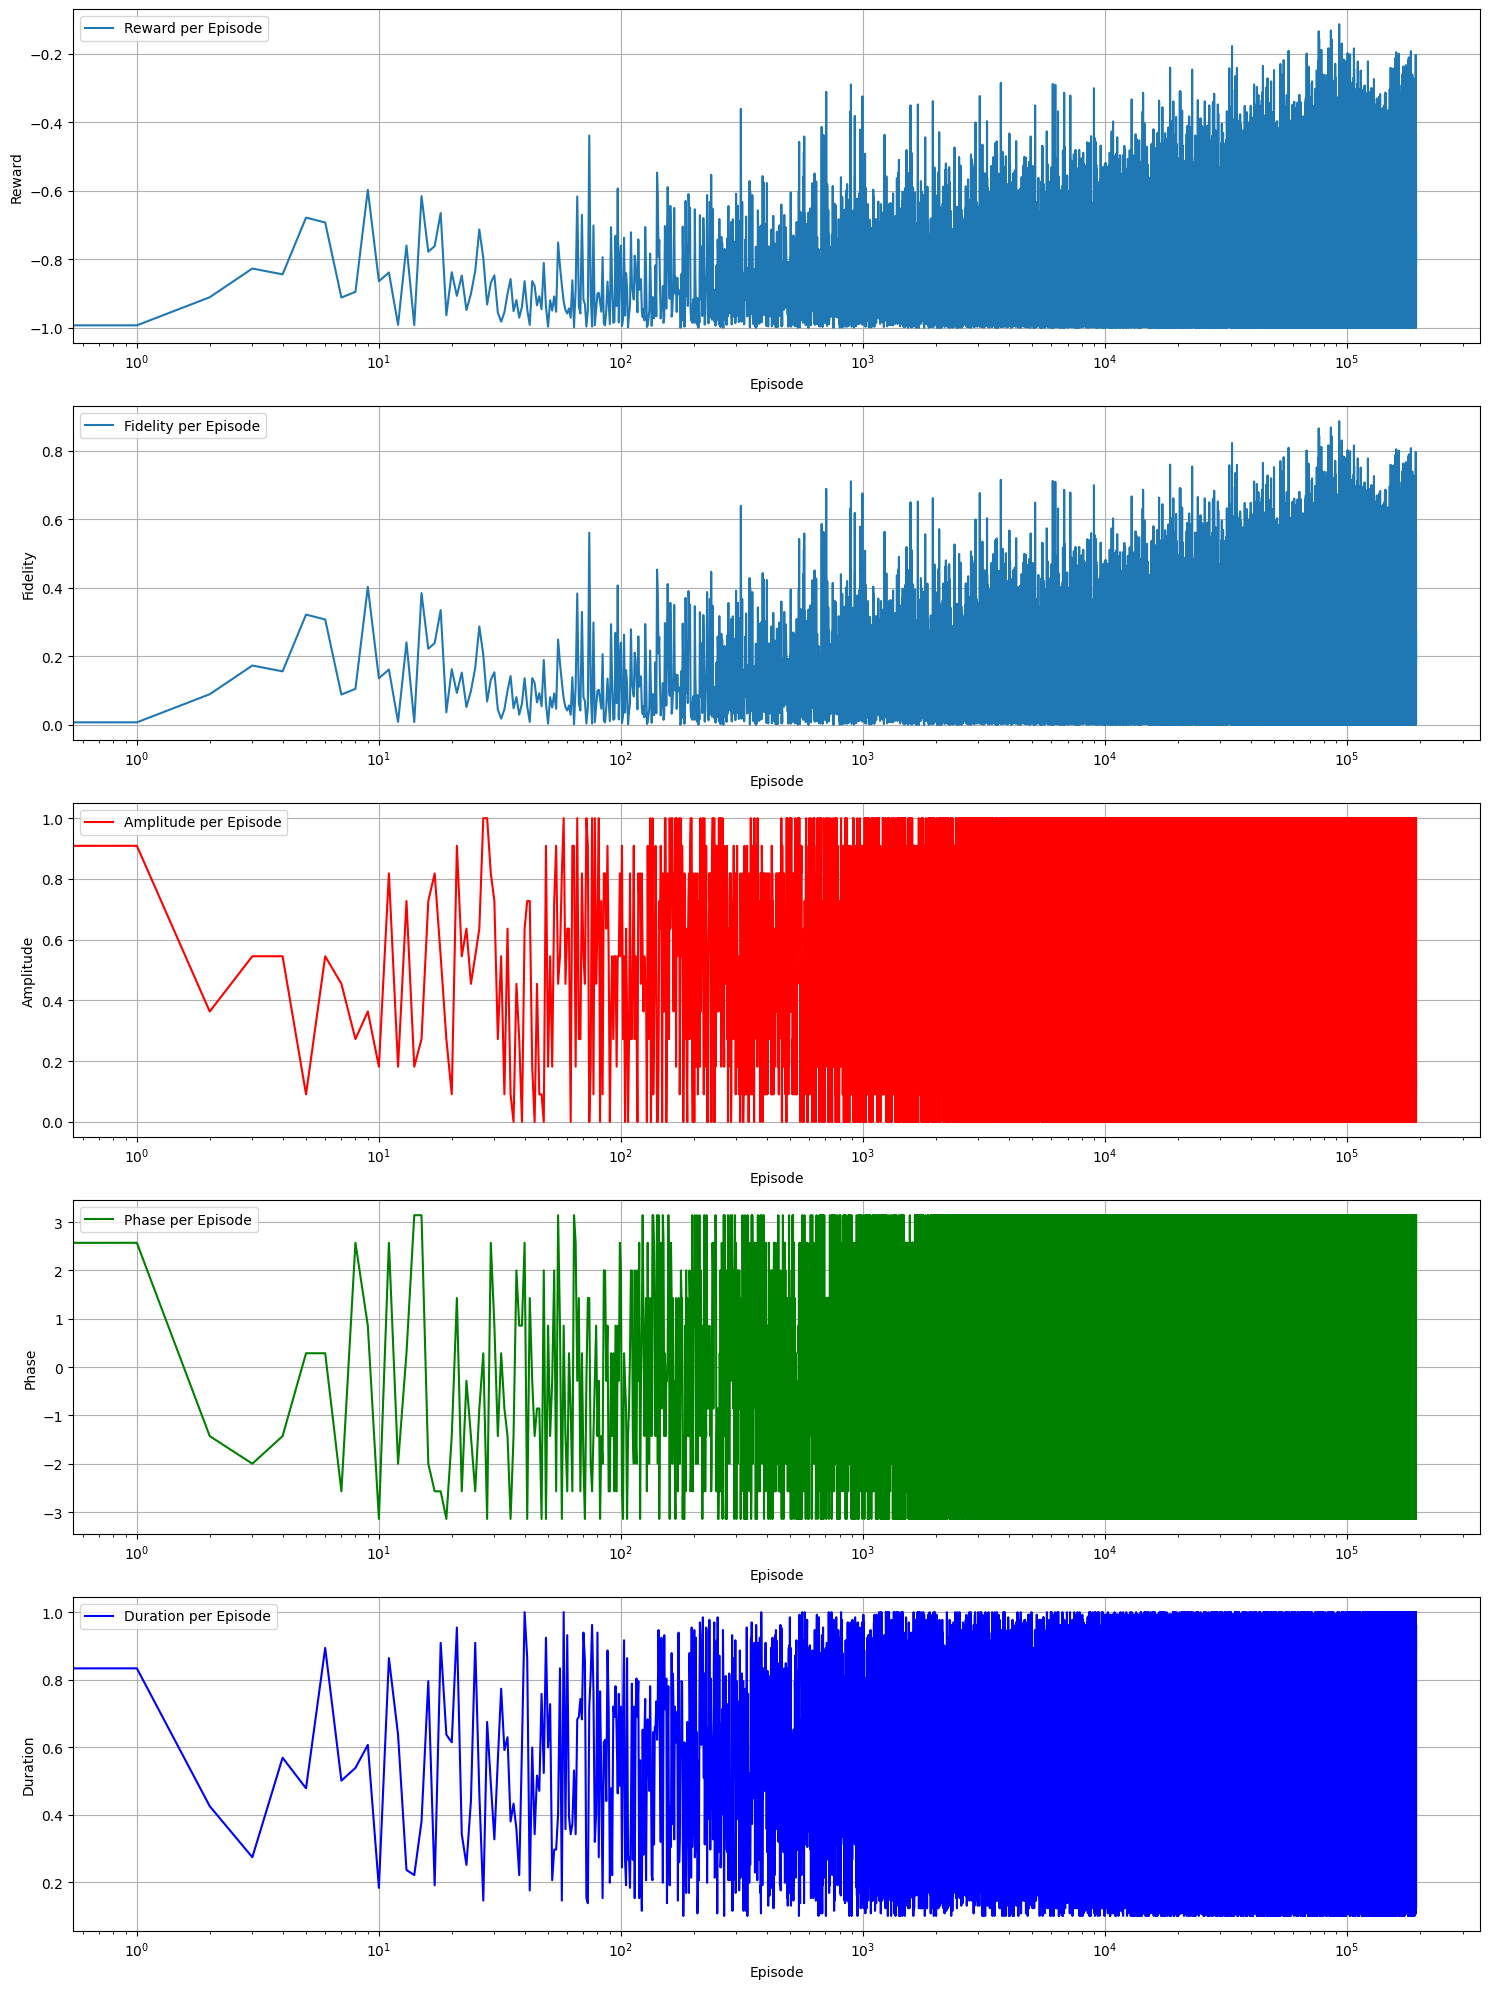

In [30]:
plot_results(
    reward_history,
    fidelity_history,
    amplitudes_history,
    phases_history,
    durations_history,
    False,
)

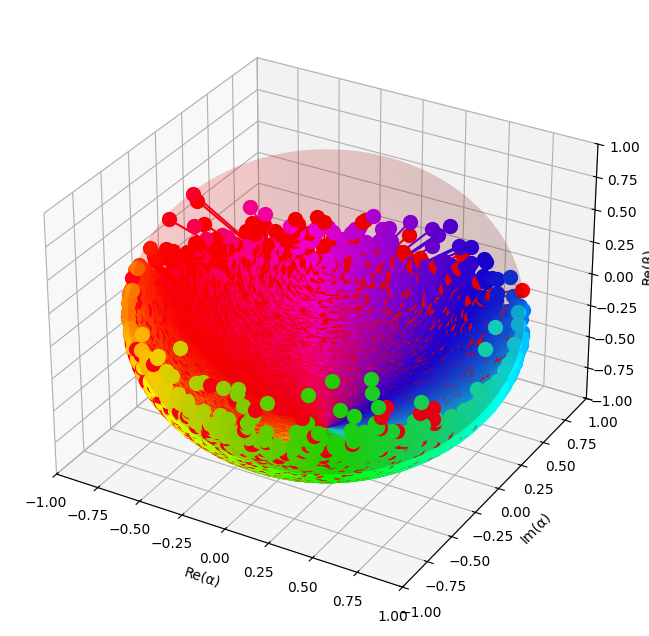

In [31]:
plot_q_sphere(state_history)

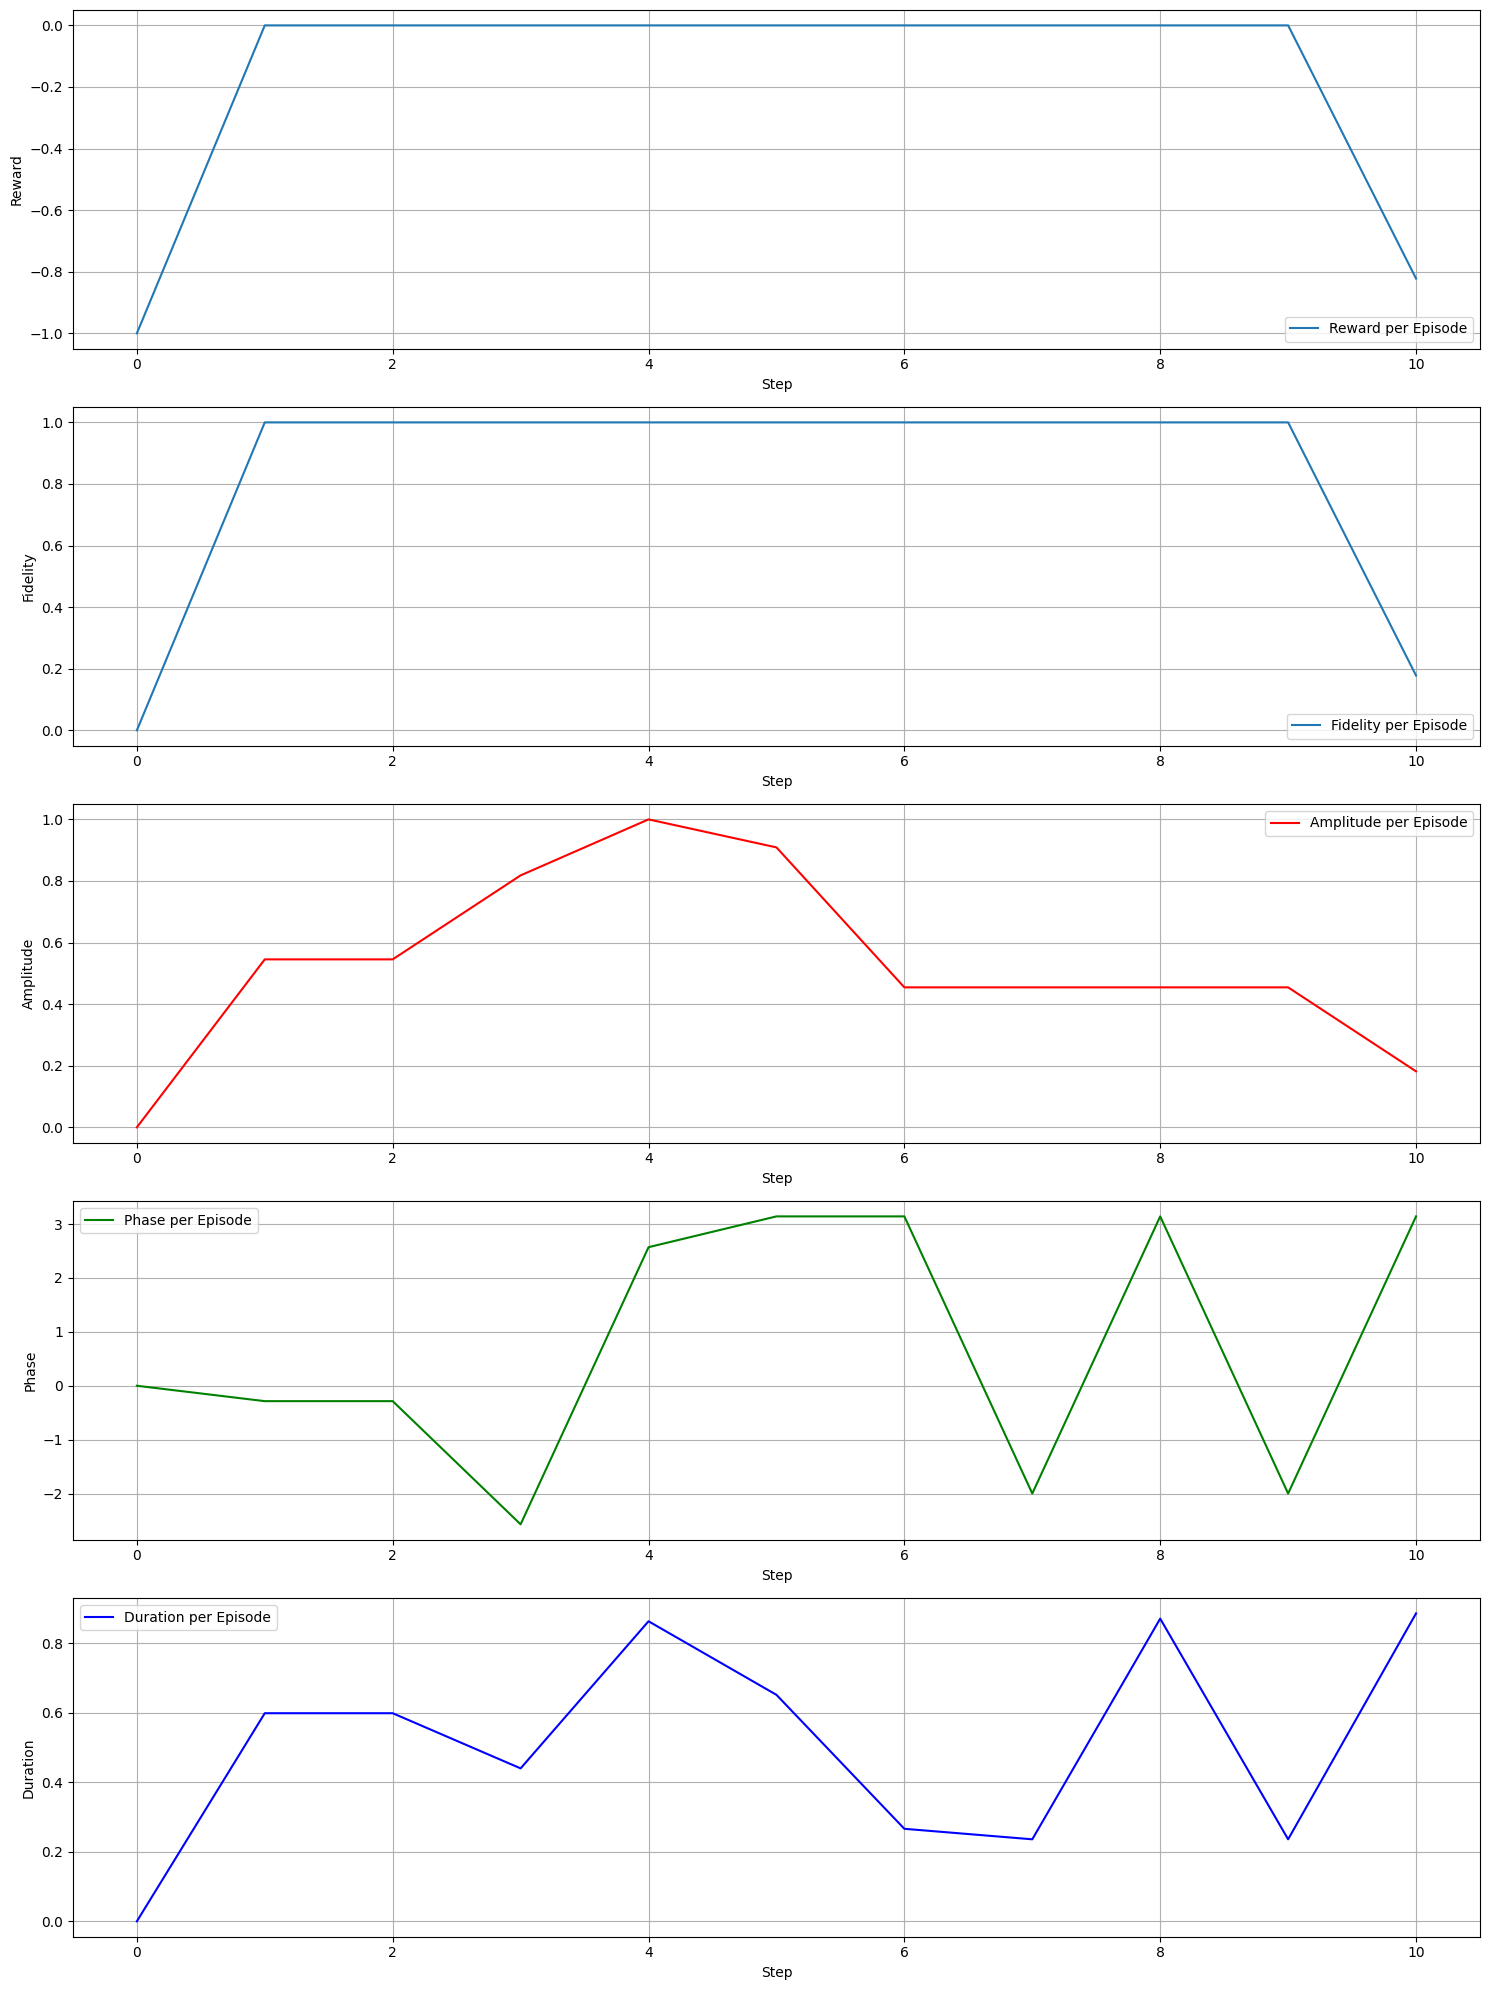

In [32]:
plot_results(
    env.reward_episode,
    env.fidelity_episode,
    env.amplitude_episode,
    env.phase_episode,
    env.duration_episode,
    True,
)

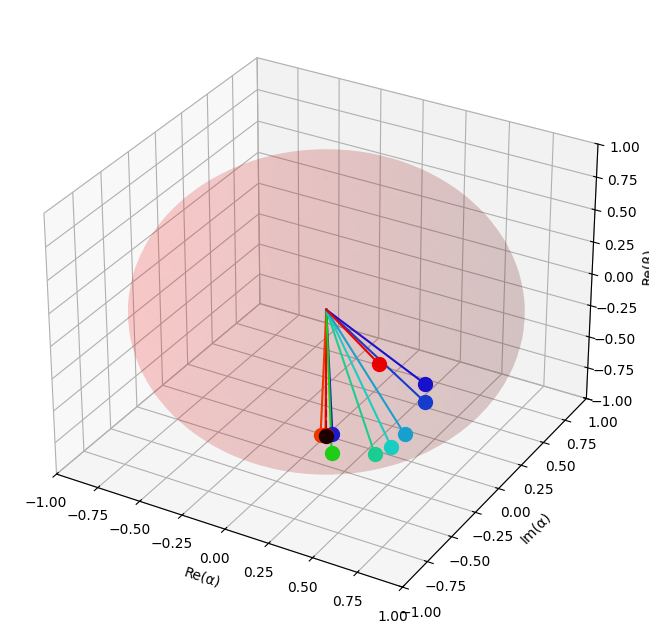

In [33]:
plot_q_sphere(env.state_episode)